<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/object_detection_for_image_cropping/play_for_beginners/squarespace_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try computer vision yourself in under 5 mintes!
#### Upload your own image and see what objects a computer vision model can find in it
---
*Last Updated 14 May 2020*   
Computer vision is a field of machine learning where computers are trained to recognize patterns. Object detection is a field within computer vision where a model is trained to identify and locate objects within an image. Object detection is so common now that many smartphones already come equipped with some form of image classifier that's used to sort your image gallery into categories like holidays, pets or even recognize friends faces.

Here, we use a pre-trained "lightweight" model known for its speed that's still relatively accurate, [YOLOv2 in Darkflow](https://github.com/thtrieu/darkflow) (the Tensorflow implementation of YOLO in Darknet) to detect objects from images. 

This notebook is meant to be run enitrely in Google Colab and doesn't require any software installations or downloads to your local machine. 

## Installs
---
Run this code block by pressing the "play" button on the left. It takes about 1-2 minutes to run and you will see some text being output beneath the block. After it is finished, scroll down to **Model Preparation**.

In [33]:
# Install required libraries
!pip install tensorflow-gpu==1.15.0rc2
!pip install imageio

# Download and build darkflow (the tensorflow implementation of YOLO)
import os
import pathlib

if "darkflow-master" in pathlib.Path.cwd().parts:
  while "darkflow-master" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path("darkflow-master").exists():
  !git clone --depth 1 https://github.com/thtrieu/darkflow.git
  # Compile darkflow
  %cd darkflow
  !python setup.py build_ext --inplace
  # Change darkflow to darkflow-master to distinguish between folder names
  %cd ../
  !mv darkflow darkflow-master

# Imports
%cd darkflow-master
%tensorflow_version 1.15.0rc2
import tensorflow as tf

# For importing/exporting files, working with arrays, etc
import time
import urllib
import numpy as np
import pandas as pd
import imageio

# For actual object detection
from darkflow.net.build import TFNet

# For drawing onto and plotting images
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format = 'svg'

/content/darkflow-master
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0rc2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


### Model Preparation
---   
Press the play button on the right. This step takes ~30 seconds. After it is finished, scroll down to **Object Detection - Find out what objects YOLO can see in your image!**

In [34]:
# Upload yolo.weights, pre-trained weights file (for YOLO v2) from Google drive 
weights = 'yolo'
weights_file = weights + '.weights'
if not os.path.exists('weights_file'):
  !gdown --id 0B1tW_VtY7oniTnBYYWdqSHNGSUU
  !mkdir bin
  !mv yolo.weights bin

# Define parameters for feeding images through the model
# Can change detection confidence threshold here
params = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolo.weights',
    'threshold': threshold, 
    'gpu': 1.0
}

# Run the model
tfnet = TFNet(params)

# For uploading an image from url
# Modified from https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

# For drawing bounding boxes around detected objects on image
def boxing(image, predictions):
    newImage = np.copy(image)
    im_height, im_width, im_depth = image.shape   
    for result in predictions:
      # Only show boxes that are above .45 confidence level
      confidence = result['confidence']
      if confidence > threshold:
        xmin = result['topleft']['x']
        ymin = result['topleft']['y']
        xmax = result['bottomright']['x']
        ymax = result['bottomright']['y']
        label = result['label'] + " " + str(round(confidence, 2))
        # Draw boxes on image
        fontScale = max(im_width,im_height)/500
        fontThickness = int(max(im_width,im_height)/200)
        newImage = cv2.rectangle(newImage, (xmin, ymax), (xmax, ymin), (255, 0, 157), 3)
        newImage = cv2.putText(newImage, label, (xmin, ymax-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 255, 255), fontThickness, cv2.LINE_AA)  
    return newImage

Downloading...
From: https://drive.google.com/uc?id=0B1tW_VtY7oniTnBYYWdqSHNGSUU
To: /content/darkflow-master/yolo.weights
204MB [00:01, 122MB/s] 
mkdir: cannot create directory ‘bin’: File exists
Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.009528875350952148s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_

## Object Detection - Find out what objects YOLO can see in your image
---
You can either **A) Load an image in by URL** or **B) Load an image in from file**. 

**A) Load in individual image by URL**   
Read in any image from a URL and see what objects YOLO can find!   
1. To get an image from a url:  
* For images from [CCSearch](https://ccsearch.creativecommons.org/), click the image you want. Next, right click the image and select "open image in new tab."  
* For images from [Google Images](https://images.google.com/), right click the image you want and select "open image in new tab."
2. Copy the url and paste it within the quotes on line 2 in the code block below.
3. Optional: Adjust the detection confidence threshold on line 6.

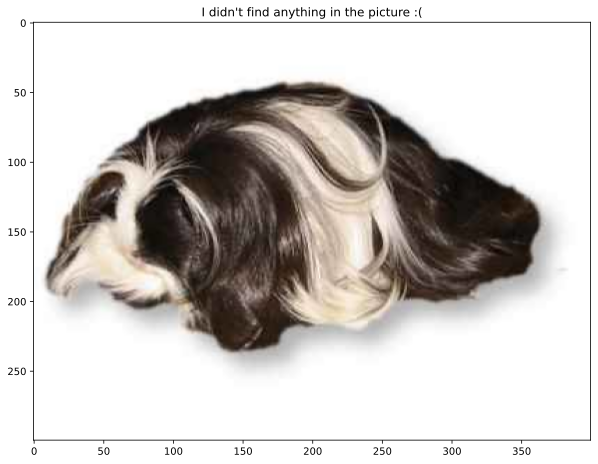

In [39]:
# Insert your URL here
url = "https://live.staticflickr.com/6132/5939378956_783cc1fb95.jpg"

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.25

# Read in image from URL
image = url_to_image(url)

# Use YOLO for object detection  
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result:
  plt.title('Wow, I found some cool stuff in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("I didn't find anything in the picture :(")

**B) Load in individual image by file**   
Read in any image from file and see what objects YOLO can find!  
To get an image from file:  
1. Click the folder icon in the left side panel. 
2. Click "Upload"
3. Select any image from your computer to upload. 
4. Copy your image filename within the quotes on line 3 in the code block below.  
5. Optional: Adjust the detection confidence threshold on line. 

In [0]:
# Insert your filename here
inpath = '/content/'
filename = 'IMG-20170516-WA0004.jpg'

# Set confidence threshold for detection
# Optional: You can adjust this value (0-1) to see more or less detected objects in the image
threshold = 0.25

# Read in image from file
fpath = inpath + filename
image = imageio.imread(fpath, pilmode='RGB')

# Use YOLO for object detection  
# Record inference time
start_time = time.time()
result = tfnet.return_predict(image)
end_time = time.time()

# Plot and show detection boxes on images
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(boxing(image, result))
# Add titles to plot
if result:
  plt.title('Wow, I found some cool stuff in {} seconds!'.format(format(end_time-start_time, '.2f')))
else:
  plt.title("I didn't find anything in the picture :(")